<a href="https://colab.research.google.com/github/Sourov1722/210123_CNN_CIFAR_10/blob/main/210123_CNN_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, torch, glob, shutil
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
import numpy as np

MY_ID = "210123"
REPO_NAME = "210123_CNN_CIFAR_10"
REPO_URL = f"https://github.com/Sourov1722/{REPO_NAME}"

if os.path.exists(REPO_NAME):
    shutil.rmtree(REPO_NAME)
!git clone {REPO_URL}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Project running on: {device}")

Cloning into '210123_CNN_CIFAR_10'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 2), reused 15 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 1.83 MiB | 29.75 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Project running on: cuda


In [3]:
# Data Preprocessing
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)

train_tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

test_tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tf)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_tf)

train_count = int(0.9 * len(full_train))
val_count = len(full_train) - train_count
train_ds, val_ds = random_split(full_train, [train_count, val_count])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:05<00:00, 29.5MB/s]


In [4]:
#  Model Architecture
class CifarNet_210123(nn.Module):
    def __init__(self):
        super(CifarNet_210123, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.fc_layers(self.conv_layers(x))

model = CifarNet_210123().to(device)

In [5]:
# Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = {'loss': [], 'acc': []}

print("Training Started...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            out = model(imgs.to(device))
            correct += (out.argmax(1) == lbls.to(device)).sum().item()

    epoch_acc = correct / val_count
    history['loss'].append(total_loss/len(train_loader))
    history['acc'].append(epoch_acc)
    print(f"Epoch {epoch+1}/10: Loss {history['loss'][-1]:.4f}, Val Acc {epoch_acc*100:.2f}%")

torch.save(model.state_dict(), f"{MY_ID}.pth")

Training Started...
Epoch 1/10: Loss 1.3236, Val Acc 60.48%
Epoch 2/10: Loss 0.9622, Val Acc 68.50%
Epoch 3/10: Loss 0.8411, Val Acc 72.34%
Epoch 4/10: Loss 0.7611, Val Acc 74.42%
Epoch 5/10: Loss 0.7059, Val Acc 74.78%
Epoch 6/10: Loss 0.6673, Val Acc 76.56%
Epoch 7/10: Loss 0.6186, Val Acc 78.12%
Epoch 8/10: Loss 0.5838, Val Acc 75.06%
Epoch 9/10: Loss 0.5547, Val Acc 79.08%
Epoch 10/10: Loss 0.5301, Val Acc 78.14%


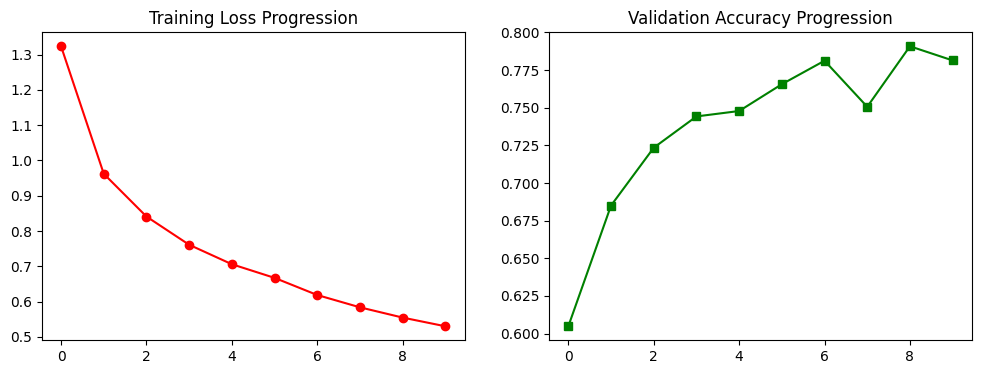

In [6]:
# Requirement: Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], color='red', marker='o')
plt.title("Training Loss Progression")

plt.subplot(1, 2, 2)
plt.plot(history['acc'], color='green', marker='s')
plt.title("Validation Accuracy Progression")
plt.show()

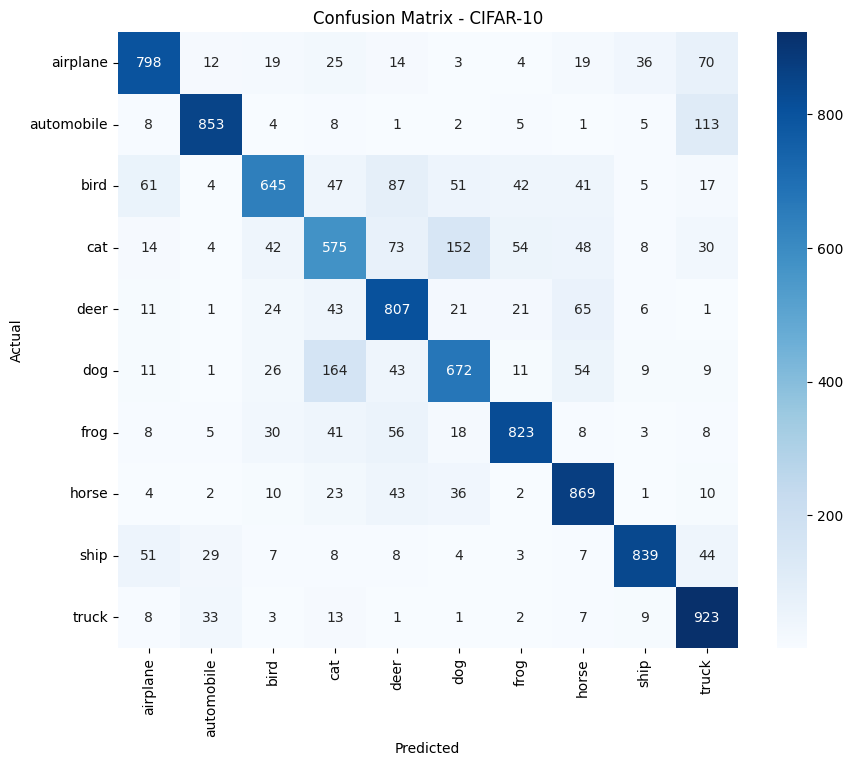

In [7]:
# Confusion Matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for imgs, lbls in test_loader:
        out = model(imgs.to(device))
        y_pred.extend(out.argmax(1).cpu().numpy())
        y_true.extend(lbls.numpy())

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - CIFAR-10")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

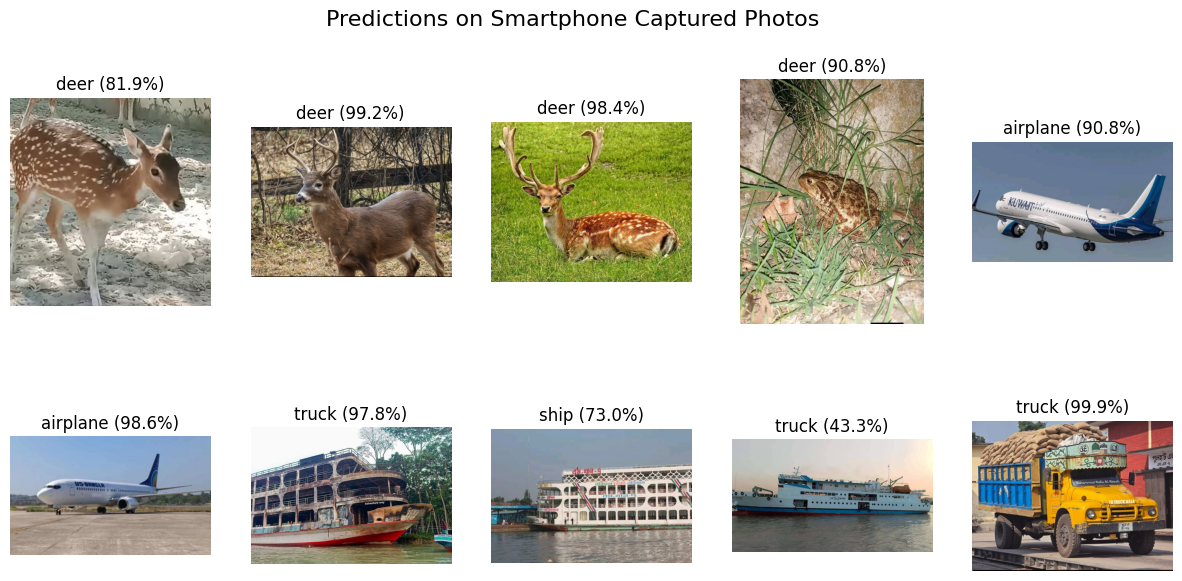

In [8]:
#Requirement: Custom Photo Predictions
custom_images = sorted(glob.glob(f"{REPO_NAME}/dataset/*"))

def predict_phone_image(img_path):
    raw = Image.open(img_path).convert("RGB")
    tensor = test_tf(raw).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(tensor)
        prob = torch.softmax(out, dim=1)
        conf, idx = torch.max(prob, 1)
    return classes[idx.item()], conf.item() * 100, raw

if custom_images:
    plt.figure(figsize=(15, 7))
    for i, p in enumerate(custom_images[:10]):
        label, conf, img = predict_phone_image(p)
        plt.subplot(2, 5, i+1)
        plt.imshow(img); plt.axis('off')
        plt.title(f"{label} ({conf:.1f}%)")
    plt.suptitle("Predictions on Smartphone Captured Photos", fontsize=16)
    plt.show()

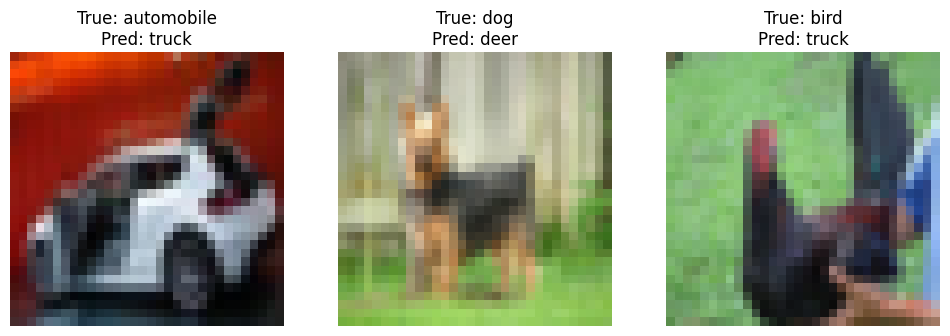

Deployment successful: 210123_CNN_CIFAR_10/model/210123.pth


In [9]:
mismatches = np.where(np.array(y_pred) != np.array(y_true))[0]
if len(mismatches) > 0:
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(mismatches[:3]):
        img_t, label = test_ds[idx]
        # Denormalize to show
        img_v = img_t.permute(1,2,0).numpy() * cifar_std + cifar_mean
        plt.subplot(1, 3, i+1)
        plt.imshow(np.clip(img_v, 0, 1))
        plt.title(f"True: {classes[label]}\nPred: {classes[y_pred[idx]]}"); plt.axis('off')
    plt.show()

os.makedirs(f"{REPO_NAME}/model", exist_ok=True)
shutil.copy(f"{MY_ID}.pth", f"{REPO_NAME}/model/{MY_ID}.pth")
print(f"Deployment successful: {REPO_NAME}/model/{MY_ID}.pth")